# Do a time-dependent POP analysis of the stratospheric polar vortex to identify slow dynamics

In [1]:
import sys
sys.path.append("../..")

In [2]:
import numpy as np
import matplotlib
from matplotlib import ticker
from matplotlib import pyplot as plt
import xarray as xr
import netCDF4 as nc
from importlib import reload
import sys 
import os
from os import mkdir, makedirs
from os.path import join,exists
from importlib import reload
import pickle
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.linear_model import LinearRegression
import datetime
from calendar import monthrange
import cartopy
from cartopy import crs as ccrs
import dask
from eofs.xarray import Eof
import pandas

In [3]:
%load_ext autoreload

In [4]:
%aimport xr_utils
%aimport feature_template
%aimport feature_stratosphere
%aimport tpt_utils
%aimport tdmc_obj

In [5]:
%matplotlib inline

In [6]:
plt.rcParams.update({"font.size": 18, "font.family": "monospace"})

In [7]:
topic_dir = "/scratch/jf4241/ecmwf_data/"
filedict = dict({
    "data": dict({
        "e5": dict({
            "traj": dict({
                "dir": join(topic_dir, "era5_data", "raw_data", "2022-08-14"), # Directory with possibly many files
            }),
        }),
        "s2": dict({
            "traj": dict({
                "dir": join(topic_dir, "s2s_data", "raw_data", "2022-08-20"), # Directory with possibly many files
            }),
        })    
    }),
    "results": dict({
        "dir": join(
            topic_dir, "results", "pops", "2022-09-23", 
            f"0"
        )
    })
})
dispdict = dict({
    "e5": dict({
        "color": "dodgerblue",
        "abbrv": "ERA5",
    }),
    "s2": dict({
        "color": "red",
        "abbrv": "S2S",
    }),
    "linear_model": dict({
        "color": "gray",
        "abborv": "Linear model",
    })
})

In [8]:
months_of_interest = [9,10,11,12,1,2,3]

In [9]:
e5 = xr.open_mfdataset(
    [join(filedict["data"]["e5"]["traj"]["dir"], f"{year:04d}-{month:02d}.nc") 
     for year in range(1980,2010) for month in months_of_interest]
).resample(time="1D").mean()

Reorganize data so that the fall year and the month are different axes

In [10]:
fall_year = e5.time.dt.year
fall_year -= 1*(e5.time.dt.month < months_of_interest[0])
fall_year_flat = fall_year.to_numpy().flatten()
szn_start_most_recent = np.array(
    [np.datetime64(f"{fall_year_flat[i]:04d}-{months_of_interest[0]:02d}-01")
     for i in range(len(fall_year_flat))]
).reshape(fall_year.shape)
t_szn = (e5.time - szn_start_most_recent)/np.timedelta64(1,"D")
year_szn = pandas.MultiIndex.from_arrays((fall_year.to_numpy(),t_szn.to_numpy()), names=("fall_year","t_szn"))
e5 = e5.assign(time=year_szn).unstack("time")
e5 = e5.isel(fall_year=slice(1,-1)) #, t_szn=slice(0,110))

Compute EOFs separately for each level (10 each). First restrict to latitudes above 20, and take a severe subselection of data (could also take monthly means). 

In [11]:
szn_duration = np.sum([monthrange(1901,month)[1] for month in months_of_interest])

In [13]:
znm = (
    e5["z"]
    .isel(latitude=np.where(e5.latitude >= 20)[0])
    #.rolling(dim={"t_szn": 5}, min_periods=1).mean()
    .isel(t_szn=np.arange(0, szn_duration, 10).astype(int))
)

(<Figure size 432x288 with 2 Axes>,
 <GeoAxesSubplot:>,
 <cartopy.crs.PlateCarree at 0x146ce8946d60>)

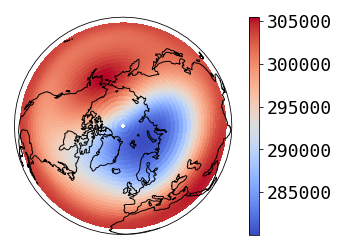

In [14]:
xr_utils.display_pole_field(znm.sel(level=10,fall_year=1981,t_szn=90), znm.latitude, znm.longitude)

In [15]:
weights = (np.cos(np.deg2rad(znm.latitude)).expand_dims({"longitude": znm.longitude})) # To make compatible with z5wn

In [16]:
# Go through each level and get EOFs and PCs for each. 
num_eofs = 10
eofs_by_level = xr.DataArray(
    coords = {"level": e5.level, "mode": np.arange(num_eofs), "latitude": znm.latitude, "longitude": znm.longitude},
    dims = ["level","mode","latitude","longitude"],
    data = np.nan,
)
eigval = xr.DataArray(
    coords = {"level": e5.level, "mode": np.arange(num_eofs)}, dims=["level","mode"]
)
zmean = xr.DataArray(
    coords={"level": e5.level, "latitude": znm.latitude, "longitude": znm.longitude}, 
    dims=["level","latitude","longitude"]
)
zvariance = xr.DataArray(
    coords={"level": e5.level}, dims=["level"]
)
for lev in znm.level.data:
    print(f"Starting level {lev}")
    zmean.loc[dict(level=lev)] = znm.sel(level=lev).mean(dim=["fall_year","t_szn"])
    solver = Eof(
        znm.sel(level=lev)
        .stack({"time": ["fall_year","t_szn"]})
        .transpose("time","latitude","longitude").load(),
        weights=weights.transpose("latitude","longitude")
    )
    eofs_by_level.loc[dict(level=lev)] = solver.eofs().isel(mode=range(num_eofs))
    eigval.loc[dict(level=lev)] = solver.eigenvalues().isel(mode=range(num_eofs))
    zvariance.loc[dict(level=lev)] = solver.eigenvalues().sum()

ds_eof = xr.Dataset({
    "eofs": eofs_by_level,
    "eigval": eigval,
    "zmean": zmean,
    "zvariance": zvariance,
})

Starting level 10
Starting level 100
Starting level 500
Starting level 850


In [17]:
ds_eof.to_netcdf(join(filedict["results"]["dir"], "ds_eofs.nc"))

In [18]:
ds_eof = xr.open_dataset(join(filedict["results"]["dir"], "ds_eofs.nc"))

(<Figure size 432x288 with 2 Axes>,
 <GeoAxesSubplot:>,
 <cartopy.crs.PlateCarree at 0x146cd20db400>)

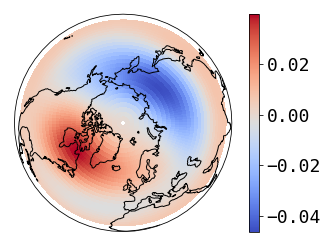

In [23]:
xr_utils.display_pole_field(ds_eof["eofs"].sel(level=10,mode=3), znm.latitude, znm.longitude)

Let's see if we can reproduce the PC timeseries

In [82]:
pc_all = (
    (ds_eof["eofs"] * (e5["z"] - ds_eof["zmean"]))
    .sum(dim=["latitude","longitude"])/np.sqrt(ds_eof["eigval"])
).compute()

To find a LIM just for winter, we need to turn this dataset into an ensemble indexed by fall year.

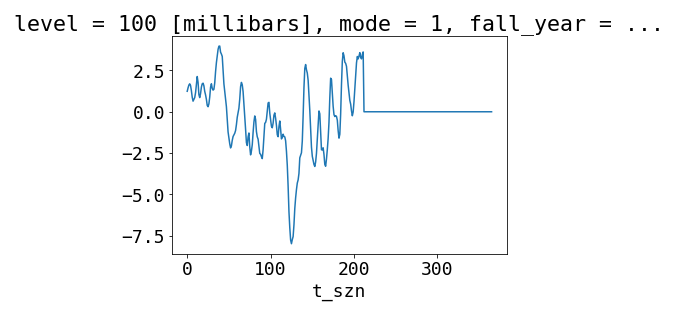

In [96]:
mode = 1
level = 100
xr.plot.plot(
    pc_all.sel(level=level, mode=mode, fall_year=1982),
    x="t_szn"
)

In [97]:
pc_all.shape

(4, 10, 29, 366)

## Now let's fit a LIM! 

First, just try a linear operator from one day to the next. 

In [99]:
X = pc_all.isel(mode=range(3)).stack({"pc": ["level","mode"]})

In [100]:
X.dims

('fall_year', 't_szn', 'pc')

In [101]:
X0 = X.isel(t_szn=0).transpose('pc','fall_year').to_numpy()
X1 = X.isel(t_szn=1).transpose('pc','fall_year').to_numpy()

In [102]:
X0.shape

(12, 29)

In [103]:
A = X1 @ X0.T @ np.linalg.inv(X0 @ X0.T)

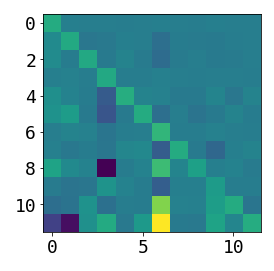

In [104]:
plt.imshow(A)

In [109]:
U,S,Vh = np.linalg.svd(A, full_matrices=False)

In [116]:
eigval,eigvec = np.linalg.eigh((A+A.T)/2)
order = np.argsort(eigval)[::-1]
eigval = eigval[order]
eigvec = eigvec[:,order]

In [117]:
eigvec[:,0]

array([-0.18915703, -0.32143836,  0.03087122,  0.07848932, -0.04081613,
       -0.05351063,  0.61070794, -0.08829439,  0.07393725,  0.08763555,
        0.29929717,  0.60478795])

In [121]:
# Combine to get the most persistent pattern
X.unstack("pc").dims

('fall_year', 't_szn', 'level', 'mode')

In [125]:
coeffs = xr.ones_like(X)
coeffs[:] = eigvec[:,0]
coeffs = coeffs.unstack("pc").isel(fall_year=0,t_szn=0)

In [126]:
coeffs

<xarray.DataArray (level: 4, mode: 3)>
array([[-0.18915703, -0.32143836,  0.03087122],
       [ 0.07848932, -0.04081613, -0.05351063],
       [ 0.61070794, -0.08829439,  0.07393725],
       [ 0.08763555,  0.29929717,  0.60478795]])
Coordinates:
    fall_year  int64 1980
    t_szn      float64 0.0
  * level      (level) int64 10 100 500 850
  * mode       (mode) int64 0 1 2

In [127]:
ds_eof.data_vars

Data variables:
    eofs       (level, mode, latitude, longitude) float64 -3.023e-09 ... -0.0...
    eigval     (level, mode) float64 1.348e+10 2.168e+09 ... 1.575e+07 1.507e+07
    zmean      (level, latitude, longitude) float64 2.901e+05 ... 1.496e+04
    zvariance  (level) float64 2.083e+10 5.268e+09 2.004e+09 4.671e+08

In [130]:
leading_eofs = coeffs.dot(ds_eof["eofs"], dims=["mode"])

In [131]:
leading_eofs.dims

('level', 'latitude', 'longitude')

(<Figure size 432x288 with 2 Axes>,
 <GeoAxesSubplot:>,
 <cartopy.crs.PlateCarree at 0x14572b74b090>)

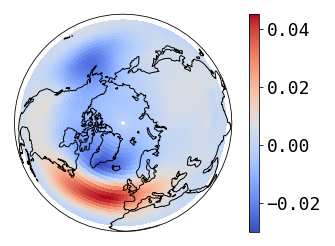

In [135]:
xr_utils.display_pole_field(leading_eofs.sel(level=850), znm.latitude, znm.longitude)